In [1]:
import os
import numpy as np
import pandas as pd
import epyestim
import epyestim.covid19 as covid19
import matplotlib.pyplot as plt
from datetime import date, timedelta
import jinja2
from pycaret.regression import *

# Calculating R
https://github.com/lo-hfk/epyestim

In [2]:
ch_cases = pd.read_csv("OxCGRT_latest_Taiwan_.csv", parse_dates=['Date']).set_index('Date')['ConfirmedCases']
ch_cases = ch_cases.fillna(0)
ch_time_varying_r = covid19.r_covid(ch_cases, n_samples=100, r_window_size=1, quantiles=(0.025, 0.25, 0.5, 0.75, 0.975))

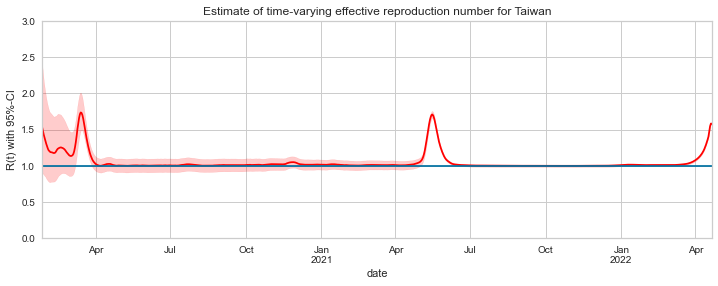

In [3]:
fig, ax = plt.subplots(1,1, figsize=(12, 4))

ch_time_varying_r.loc[:,'Q0.5'].plot(ax=ax, color='red')
ax.fill_between(ch_time_varying_r.index, ch_time_varying_r['Q0.025'], ch_time_varying_r['Q0.975'], color='red', alpha=0.2)
ax.set_xlabel('date')
ax.set_ylabel('R(t) with 95%-CI')
ax.set_ylim([0,3])
ax.axhline(y=1)
ax.set_title('Estimate of time-varying effective reproduction number for Taiwan')
plt.show()

In [4]:
y = ch_time_varying_r['R_mean']

# Oxford COVID-19 Government Response Tracker
https://www.bsg.ox.ac.uk/research/research-projects/covid-19-government-response-tracker
## Preprocess Dataset

In [5]:
df = pd.read_csv("OxCGRT_latest_Taiwan_.csv", parse_dates=['Date'])#.set_index('Date') #.applymap(lambda x: x.date()+timedelta(7))
df = df.fillna(0)
df['Date']= df['Date'].map(lambda t: t.date()+timedelta(14)) # 14
df = df.set_index('Date')
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 845 entries, 2020-01-22 to 2022-05-15
Data columns (total 57 columns):
 #   Column                                                                           Non-Null Count  Dtype  
---  ------                                                                           --------------  -----  
 0   CountryName                                                                      845 non-null    object 
 1   CountryCode                                                                      845 non-null    object 
 2   C1_School closing                                                                845 non-null    int64  
 3   C1_Flag                                                                          845 non-null    float64
 4   C2_Workplace closing                                                             845 non-null    int64  
 5   C2_Flag                                                                          845 non-null    float64
 6  

In [6]:
X = df[['C1_School closing','C2_Workplace closing','C3_Cancel public events','C4_Restrictions on gatherings','C5_Close public transport','C6_Stay at home requirements',
        'C7_Restrictions on internal movement','C8_International travel controls',
        'E1_Income support','E2_Debt/contract relief','E3_Fiscal measures',
        'H1_Public information campaigns','H2_Testing policy','H3_Contact tracing','H4_Emergency investment in healthcare','H5_Investment in vaccines','H6_Facial Coverings',
        'H7_Vaccination policy','H8_Protection of elderly people',
        'V1_Vaccine Prioritisation (summary)','V2A_Vaccine Availability (summary)','V2D_Medically/ clinically vulnerable (Non-elderly)',
        'V2E_Education','V2F_Frontline workers  (non healthcare)','V2G_Frontline workers  (healthcare)','V4_Mandatory Vaccination (summary)']] # ,'V3_Vaccine Financial Support (summary)'
df_shift = pd.merge(X, y, left_index=True, right_index=True)
X = df_shift.drop(["R_mean"], axis=1)
y = df_shift["R_mean"]

## Training

In [7]:
s = setup(data = df_shift, target = 'R_mean', session_id=123)

,Description,Value
0,session_id,123
1,Target,R_mean
2,Original Data,"(816, 27)"
3,Missing Values,False
4,Numeric Features,6
5,Categorical Features,20
6,Ordinal Features,False
7,High Cardinality Features,False
8,High Cardinality Method,None
9,Transformed Train Set,"(571, 54)"


In [8]:
best = compare_models()

,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE,TT (Sec)
rf,Random Forest Regressor,0.0191,0.0025,0.0478,0.8726,0.0202,0.0153,0.1050
catboost,CatBoost Regressor,0.0191,0.0025,0.0481,0.8706,0.0203,0.0152,0.9550
dt,Decision Tree Regressor,0.0189,0.0025,0.0481,0.8704,0.0203,0.0150,0.0070
gbr,Gradient Boosting Regressor,0.0202,0.0025,0.0483,0.8702,0.0204,0.0162,0.0430
et,Extra Trees Regressor,0.0190,0.0025,0.0482,0.8699,0.0203,0.0151,0.0990
xgboost,Extreme Gradient Boosting,0.0195,0.0027,0.0496,0.8628,0.0209,0.0156,0.0710
lightgbm,Light Gradient Boosting Machine,0.0230,0.0030,0.0529,0.8461,0.0223,0.0186,0.0230
ada,AdaBoost Regressor,0.0265,0.0032,0.0537,0.8394,0.0229,0.0222,0.0130
knn,K Neighbors Regressor,0.0212,0.0032,0.0549,0.8222,0.0232,0.0167,0.0090
ridge,Ridge Regression,0.0406,0.0051,0.0697,0.7130,0.0305,0.0350,0.0060


## Interpret Random Forest model

In [9]:
rf = create_model('rf')
tuned_rf = tune_model(rf)
print(tuned_rf)

,MAE,MSE,RMSE,R2,RMSLE,MAPE
Fold,,,,,,
0,0.0183,0.0017,0.0418,0.8806,0.0173,0.0150
1,0.0228,0.0019,0.0434,0.8536,0.0188,0.0194
2,0.0379,0.0064,0.0801,0.7785,0.0330,0.0290
3,0.0158,0.0009,0.0303,0.9097,0.0134,0.0143
4,0.0298,0.0038,0.0617,0.7765,0.0259,0.0246
5,0.0311,0.0048,0.0695,0.8149,0.0289,0.0237
6,0.0178,0.0019,0.0432,0.7956,0.0176,0.0152
7,0.0287,0.0029,0.0543,0.8569,0.0229,0.0235
8,0.0357,0.0061,0.0783,0.7968,0.0320,0.0267


RandomForestRegressor(bootstrap=False, ccp_alpha=0.0, criterion='mse',
                      max_depth=8, max_features='sqrt', max_leaf_nodes=None,
                      max_samples=None, min_impurity_decrease=0.0001,
                      min_impurity_split=None, min_samples_leaf=2,
                      min_samples_split=5, min_weight_fraction_leaf=0.0,
                      n_estimators=240, n_jobs=-1, oob_score=False,
                      random_state=123, verbose=0, warm_start=False)


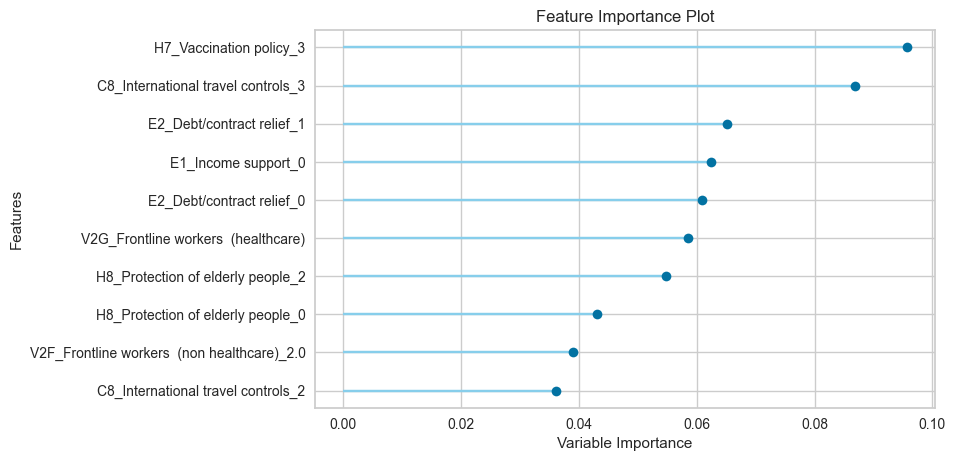

In [10]:
plot_model(tuned_rf, plot='feature')

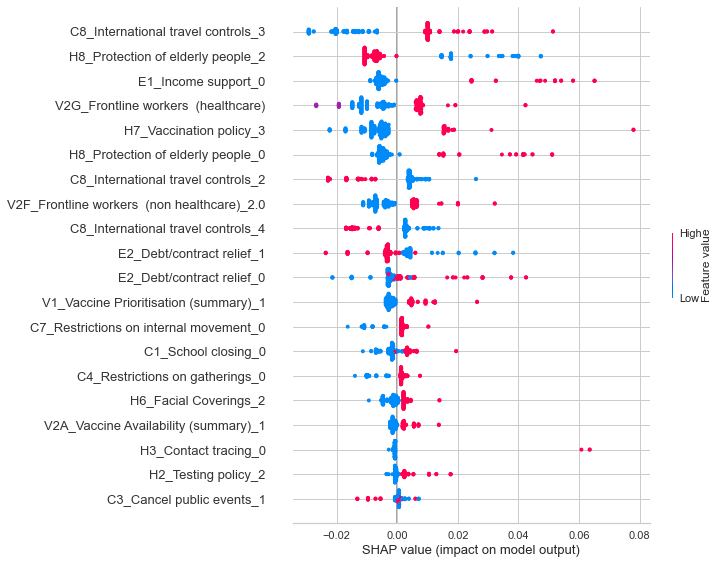

In [11]:
interpret_model(tuned_rf)

In [12]:
predict_model(tuned_rf)

,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Random Forest Regressor,0.0191,0.0015,0.0383,0.8494,0.0164,0.0167


,E3_Fiscal measures,H4_Emergency investment in healthcare,V2D_Medically/ clinically vulnerable (Non-elderly),V2E_Education,V2G_Frontline workers (healthcare),V4_Mandatory Vaccination (summary),C1_School closing_0,C1_School closing_1,C1_School closing_2,C1_School closing_3,...,H8_Protection of elderly people_0,H8_Protection of elderly people_2,H8_Protection of elderly people_3,V1_Vaccine Prioritisation (summary)_1,V1_Vaccine Prioritisation (summary)_2,V2A_Vaccine Availability (summary)_1,V2A_Vaccine Availability (summary)_3,V2F_Frontline workers (non healthcare)_2.0,R_mean,Label
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.017568,1.019550
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.007676,1.018631
2,0.0,0.0,2.0,1.0,2.0,0.0,0.0,0.0,1.0,0.0,...,0.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,1.002174,1.009017
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.013145,1.018631
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0,1.002923,1.014948
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
240,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.044115,1.018631
241,0.0,0.0,2.0,2.0,2.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,1.0,0.0,1.0,0.0,1.0,1.0,1.015669,1.035090
242,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,...,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,1.015848,1.036652
243,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.001344,1.020050


In [13]:
final_rf = finalize_model(tuned_rf)
print(final_rf)

RandomForestRegressor(bootstrap=False, ccp_alpha=0.0, criterion='mse',
                      max_depth=8, max_features='sqrt', max_leaf_nodes=None,
                      max_samples=None, min_impurity_decrease=0.0001,
                      min_impurity_split=None, min_samples_leaf=2,
                      min_samples_split=5, min_weight_fraction_leaf=0.0,
                      n_estimators=240, n_jobs=-1, oob_score=False,
                      random_state=123, verbose=0, warm_start=False)


In [14]:
save_model(final_rf,'Final_RF_Model_20May2022')

Transformation Pipeline and Model Successfully Saved


(Pipeline(memory=None,
          steps=[('dtypes',
                  DataTypes_Auto_infer(categorical_features=[],
                                       display_types=True, features_todrop=[],
                                       id_columns=[], ml_usecase='regression',
                                       numerical_features=[], target='R_mean',
                                       time_features=[])),
                 ('imputer',
                  Simple_Imputer(categorical_strategy='not_available',
                                 fill_value_categorical=None,
                                 fill_value_numerical=None,
                                 numeric_strategy=...
                  RandomForestRegressor(bootstrap=False, ccp_alpha=0.0,
                                        criterion='mse', max_depth=8,
                                        max_features='sqrt', max_leaf_nodes=None,
                                        max_samples=None,
                               